### Exact vs 4th Order Runge-Kutta Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.animation as animation
import scipy
import math

In [2]:
g = 9.81      # gravitational acceleration (m/s^2)
m = 0.5       # mass of pendulum (kg)
l = 0.5       # length of pendulum (m)
b = 0.1       # Damping coefficient (Ns/m)
dt = 0.01     # time step for integration (s)
T = 10        # total simulation time (s)

In [3]:
# Initial conditions
theta_0 = np.pi/2        # initial angle (0 degrees)
omega_0 = 0.0        # initial angular velocity

In [4]:
# Initialize arrays to store the results
time = np.arange(0, T+dt, dt)
theta_Euler = np.zeros(len(time))
omega_Euler = np.zeros(len(time))
theta_RK4 = np.zeros(len(time))
omega_RK4 = np.zeros(len(time))

theta_Euler[0] = theta_0
omega_Euler[0] = omega_0 
theta_RK4[0] = theta_0
omega_RK4[0] = omega_0

In [5]:
# Numerical integration using Euler's method
def Euler(alpha, theta, omega, dt):
    omega = omega + alpha * dt
    theta = theta + omega * dt
    return theta, omega

In [6]:
for i in range(1, len(time)):
    # Compute angular acceleration
    alpha = -(b / (m*l**2)) * omega_Euler[i - 1] - (g / l) * np.sin(theta_Euler[i - 1]) 
    
    # Update angular velocity and angle
    theta_Euler[i], omega_Euler[i] = Euler(alpha, theta_Euler[i-1], omega_Euler[i-1], dt)

In [7]:
# Numerical integration using Runge-Kutta 4th order method
def derivatives(theta, omega):
    theta_dot = omega
    theta_ddot = -(b / (m*l**2)) * omega - (g / l) * np.sin(theta)
    return theta_dot, theta_ddot
    
    
def RK4(theta, omega, dt):
    k1_theta, k1_omega = derivatives(theta, omega)
    k2_theta, k2_omega = derivatives(theta + 0.5 * dt * k1_theta, omega + 0.5 * dt * k1_omega)
    k3_theta, k3_omega = derivatives(theta + 0.5 * dt * k2_theta, omega + 0.5 * dt * k2_omega)
    k4_theta, k4_omega = derivatives(theta + dt * k3_theta, omega + dt * k3_omega)
    
    theta = theta + (dt / 6.0) * (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)
    omega = omega + (dt / 6.0) * (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega)
    
    return theta, omega

In [8]:
for i in range(1, len(time)):
    
    # Update angular velocity and angle
    theta_RK4[i], omega_RK4[i] = RK4(theta_RK4[i-1], omega_RK4[i-1], dt)

<IPython.core.display.Javascript object>


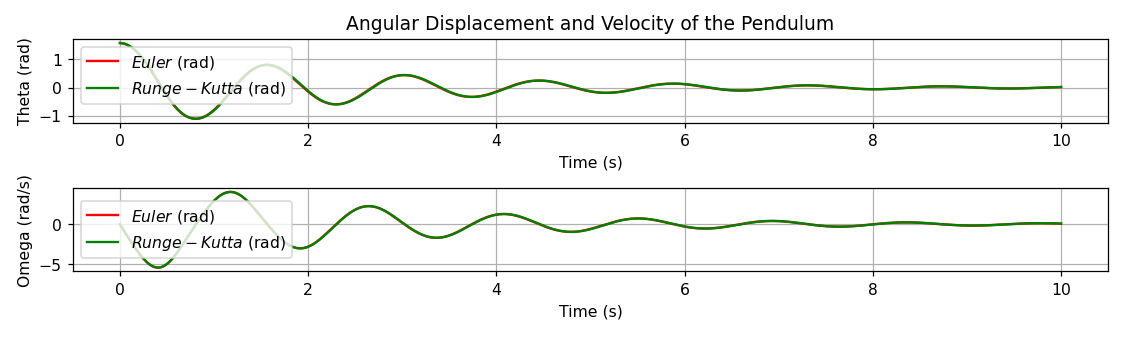

In [9]:
# Plot results
plt.figure(figsize=(10, 3))

# Plot theta vs time
plt.subplot(2, 1, 1)
plt.plot(time, theta_Euler, color='r', label=r'$Euler$ (rad)')
plt.plot(time, theta_RK4, color='g',  label=r'$Runge-Kutta$ (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Angular Displacement and Velocity of the Pendulum')
plt.legend()
plt.grid()

# Plot omega vs time
plt.subplot(2, 1, 2)
plt.plot(time, omega_Euler, color='r', label=r'$Euler$ (rad)')
plt.plot(time, omega_RK4, color='g', label=r'$Runge-Kutta$ (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Omega (rad/s)')
plt.legend()
plt.grid()



# Show plot
plt.tight_layout()


<IPython.core.display.Javascript object>


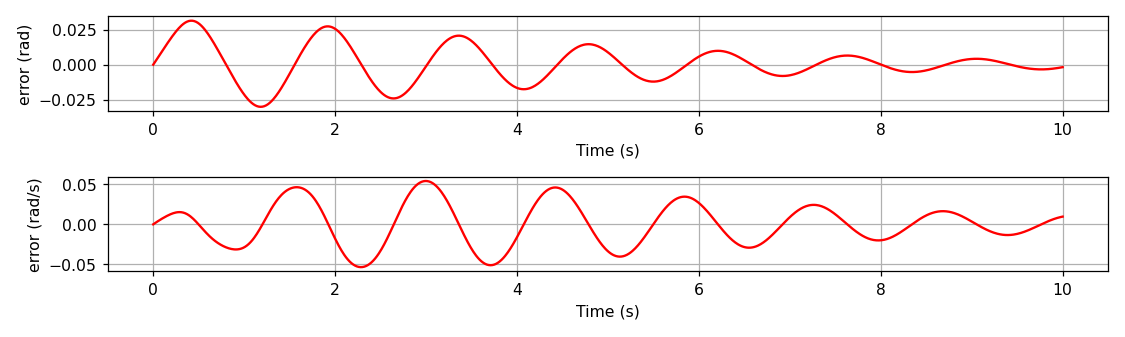

In [10]:
# Plot results
plt.figure(figsize=(10, 3))

# Plot Theta error vs time
plt.subplot(2, 1, 1)
plt.plot(time, theta_RK4 - theta_Euler, color='r')
plt.xlabel('Time (s)')
plt.ylabel('error (rad)')
plt.grid()

# Plot Omega error vs time
plt.subplot(2, 1, 2)
plt.plot(time, omega_RK4 - omega_Euler, color='r')
plt.xlabel('Time (s)')
plt.ylabel('error (rad/s)')
plt.grid()

# Show plot
plt.tight_layout()

### Stability with LQR Controller

In [11]:
# Initial conditions
theta_0 = 0.1          # initial angle (0 degrees)
omega_0 = 0.0        # initial angular velocity

In [12]:
# Final conditions
theta_f = np.pi      # final angle (180 degrees)
omega_f = 0.0        # final angular velocity

In [13]:
# Initialize arrays to store the results
time = np.arange(0, T+dt, dt)
theta_RK4 = np.zeros(len(time))
omega_RK4 = np.zeros(len(time))

theta_RK4[0] = theta_0
omega_RK4[0] = omega_0
theta_RK4[-1] = theta_f
omega_RK4[-1] = omega_f

In [14]:
# Linearized State-Space Matrices
A = np.array([[0, 1],
              [-g / l, -b / (m * l**2)]])
B = np.array([[0], [1 / (m * l**2)]])


In [15]:
# LQR weight matrices
Q = np.array([[10, 1],
              [1, 10]])  # Penalize theta 
R = np.array([[1]])   # Penalize control effort

In [16]:
# Solve the continuous-time algebraic Riccati equation
P = scipy.linalg.solve_continuous_are(A, B, Q, R)

# Calculate the LQR gain
K = np.dot(np.linalg.inv(R), np.dot(B.T, P))
K_e = 10


In [17]:
# Numerical integration using Runge-Kutta 4th order method
def derivatives(theta, omega):
    theta_dot = omega
    E_des = m*l*g;   # desired energy
    E_curr = 0.5*m*(l**2)*(omega**2) - m*l*g*np.cos(theta)
    Tau = -K_e * omega * (E_curr - E_des) + b * omega

    if theta == np.pi:
        state = np.array([[theta - np.pi], [omega]])  # State deviation from upright
        Tau = -np.dot(K, state)[0, 0]  # Control input
    
    Tau = np.clip(Tau, -1, 1)  # Limit the torque 
    theta_ddot = -(b / (m*l**2)) * omega - (g / l) * np.sin(theta) + Tau/(m*l**2)
    return theta_dot, theta_ddot
    
    
def RK4(theta, omega, dt):
    k1_theta, k1_omega = derivatives(theta, omega)
    k2_theta, k2_omega = derivatives(theta + 0.5 * dt * k1_theta, omega + 0.5 * dt * k1_omega)
    k3_theta, k3_omega = derivatives(theta + 0.5 * dt * k2_theta, omega + 0.5 * dt * k2_omega)
    k4_theta, k4_omega = derivatives(theta + dt * k3_theta, omega + dt * k3_omega)
    
    theta = theta + (dt / 6.0) * (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)
    omega = omega + (dt / 6.0) * (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega)
    
    return theta, omega

In [18]:
for i in range(1, len(time)):
    
    # Update angular velocity and angle
    theta_RK4[i], omega_RK4[i] = RK4(theta_RK4[i-1], omega_RK4[i-1], dt)

<IPython.core.display.Javascript object>


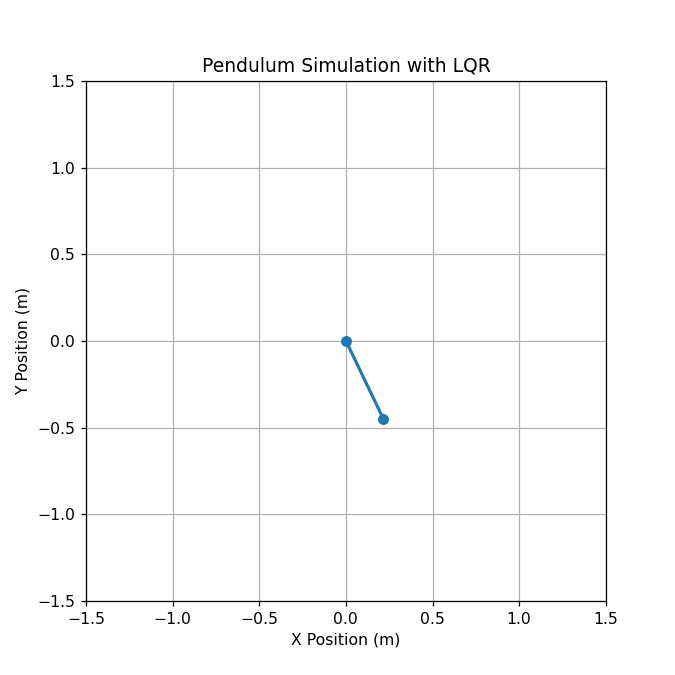

In [19]:
# Visualization
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([0, l * np.sin(theta_RK4[0])], [0, -l * np.cos(theta_RK4[0])])
    return line,

def update(frame):
    x = l * np.sin(theta_RK4[frame])
    y = -l * np.cos(theta_RK4[frame])
    line.set_data([0, x], [0, y])
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(time), init_func=init, blit=True, interval=dt*1000)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Pendulum Simulation with LQR")
plt.show()

